*Analysing Worldwide food/feed production between the years 1961 - 2013*


**Author:** Anas Suffo


# Introduction



# Libraries

## following are the libraries needed for analysing the dataset:

In [1]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(stringr)
library(tibble)
library(forcats)
library(sp)
library(rworldmap)
library(cowplot)
library(forecast)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


### Welcome to rworldmap ###

For a short introduction type : 	 vignette('rworldmap')

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



# Data Import

The dataset as illustrated in the Readme file is constructed of information about the amount of production for each country in the period between 1961 and 2013. Two main kinds of production: food and feed. Food: refers to the total amount of the food item available as human food during the reference period. Feed: 

In [2]:
fao <- read.csv("C:/Users/Anas Suffo/OneDrive/R/data/48hrSfAD/48hourSfAD/FAO.csv")

The dataset has 21477 observations and 63 variables, where we have details of Food and Feed production by country from 1961 to 2013, including geocoding of Countries. The Element code describes the code given to Food(5142) and Feed(5521) and all the measurements are in 1000 tonnes. We have different Food and Feed items and their codes such as wheat & products, barley & products, maize & products, bananas, grapes and so on

In [3]:
colnames(fao)[1] <- "Area_Abb"
colnames(fao)[2] <- "Area_Code"
colnames(fao)[3] <- "Area"
colnames(fao)[4] <- "Item_Code"
colnames(fao)[5] <- "Item"
colnames(fao)[6] <- "Element_Code"
colnames(fao)[7] <- "Element"

fao_sel <- fao[,-c(2,4,6,8,9,10)]

fao_gath <- fao_sel %>% 
    gather(Year, Production, Y1961:Y2013, na.rm = TRUE) %>% 
    group_by(Area_Abb,Element) %>%
    mutate(Year = stringr::str_remove(Year, "Y"))

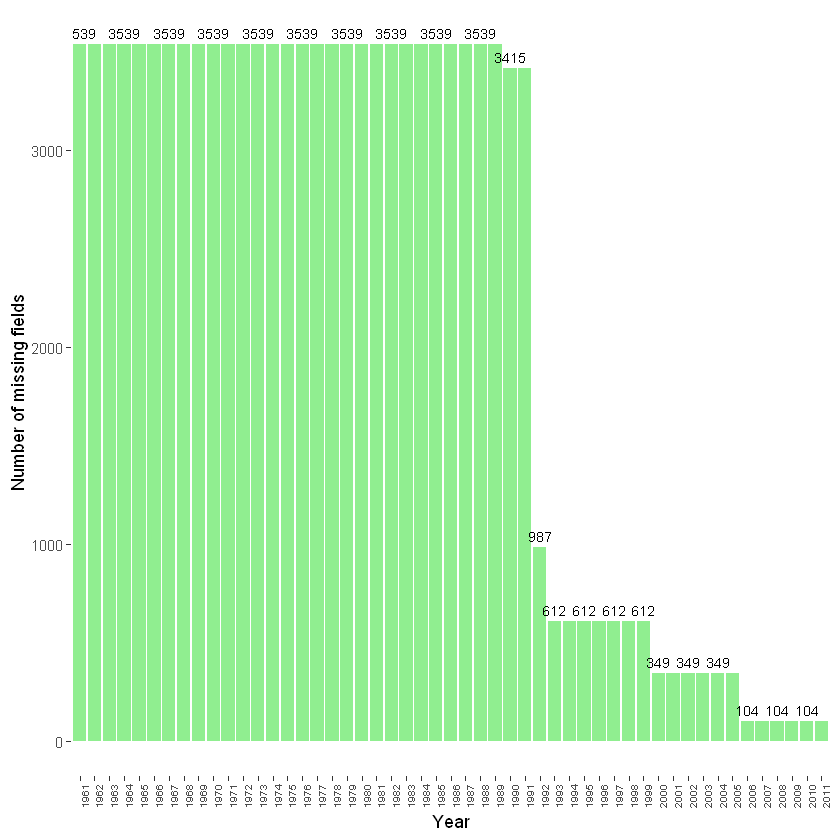

In [4]:
# to see how many missing values there are in each year:
fao_sel %>% 
    gather(Year, Production, Y1961:Y2013) %>% 
    filter(is.na(Production)) %>% 
    group_by(Year)%>% tally() %>%
    mutate(Year = stringr::str_remove(Year, "Y")) %>%
    ggplot(aes(Year,n))+
    geom_col(fill = "lightgreen")+
    theme(axis.text.x = element_text(size=6, angle=90),
          panel.background = element_blank())+
    geom_text(aes(label = sprintf("%d", n)), hjust = 0.5,
              vjust = -0.5, size = 3, check_overlap = TRUE)+
    ylab("Number of missing fields")

`summarise()` has grouped output by 'Element'. You can override using the `.groups` argument.



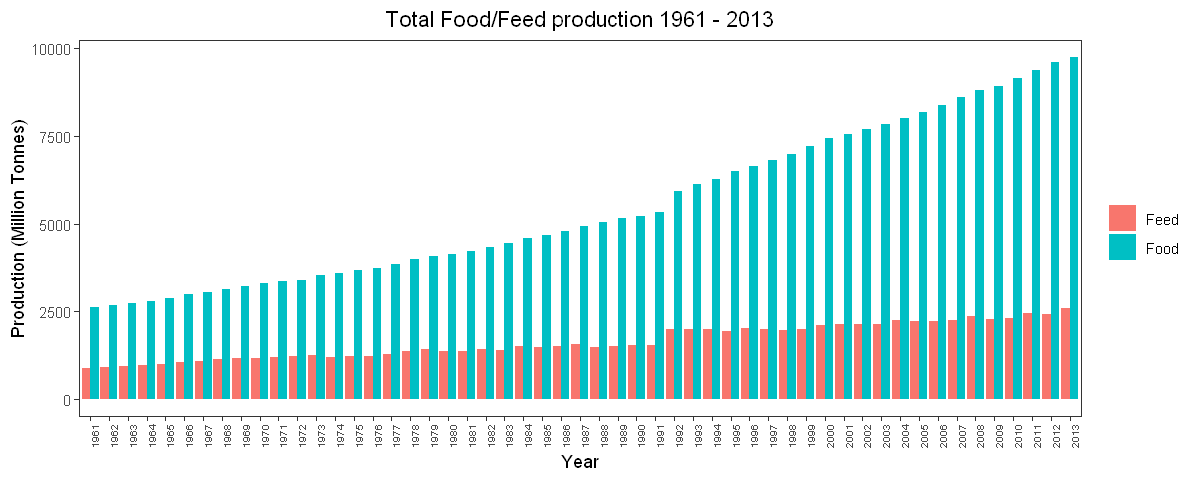

In [5]:
# the trend for total feed and food production over the years
options(repr.plot.width=10, repr.plot.height=4)
fao_sel %>% 
    gather(Year, Production, Y1961:Y2013, na.rm = TRUE) %>% 
    group_by(Element,Year)%>% # to see production development for feed and food per year
    summarise(Production = sum(Production)/1000)%>% # to get the values in million tonnes
    mutate(Year = stringr::str_remove(Year, "Y")) %>%
    ggplot(aes(Year,Production,group = Element))+  
    geom_col(aes(fill = Element),position = "dodge") + # bars of food and feed next to each other
    theme_bw()+theme(axis.text.x = element_text(size=6, angle=90),
                     plot.title = element_text(hjust = 0.5),
                     panel.grid = element_blank(),legend.title = element_blank())+
    ylab( "Production (Million Tonnes)")+
    ggtitle ( "Total Food/Feed production 1961 - 2013")


`summarise()` has grouped output by 'Area_Abb'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Area_Abb'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Area_Abb', 'Year'. You can override using the `.groups` argument.



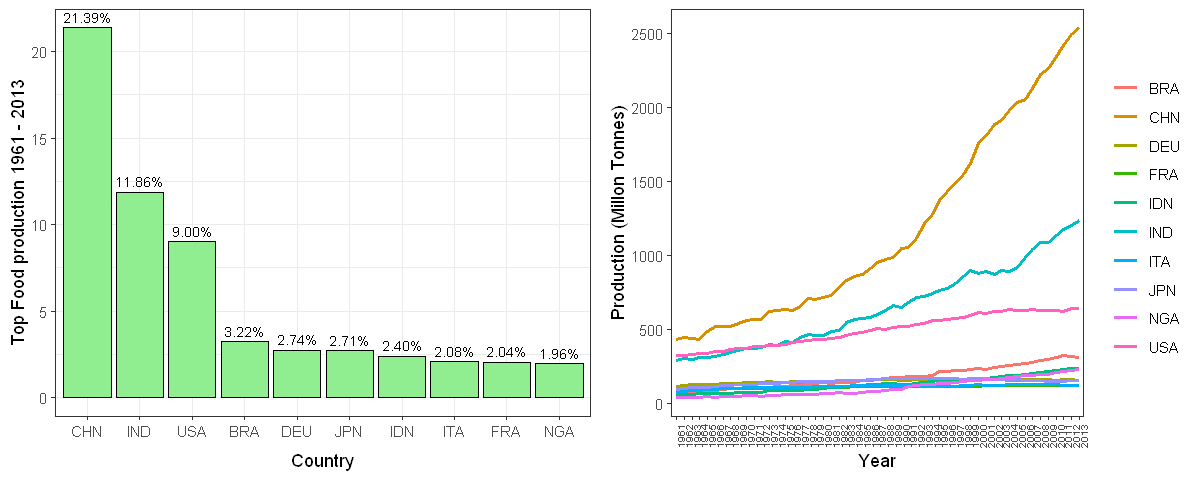

In [6]:
# the top 10 food producers
topFood <- fao_gath%>%
    filter(Element == "Food")  %>% # selecting the food only
    summarise(totalprod = sum(Production)/1000)%>% # getting the total production for food
    ungroup()%>% 
    top_n(10,totalprod)

# to see the top 10 countries for food production:
# topFood %>% select(Area_Abb,totalprod) %>% arrange(desc(totalprod)) # in millions of tonnes

# using bar plot to plot top food producers:
options(repr.plot.width=10, repr.plot.height=4)
fao <- mutate(fao, Total=apply(fao[11:63], 1, sum, na.rm = T))
fao <- mutate(fao, last5=apply(fao[58:63], 1, sum, na.rm = T))
top_food1 <- fao %>% group_by(Area_Abb, Element) %>%filter(Element == 'Food')%>% 
    summarise(TFO = sum(Total)) %>% ungroup()%>%mutate(pct = prop.table(TFO)*100)%>%
    top_n(10, wt = pct) %>% 
    ggplot(aes(x = reorder(Area_Abb, -pct), y = pct)) + 
    geom_bar(stat = 'identity', fill = "lightgreen", aes(color = I('black')), size = 0.1) + 
    geom_text(aes(label = sprintf("%.2f%%", pct)), hjust = 0.5,
              vjust = -0.5, size = 3)+ theme_bw()+ xlab("Country") + ylab("Top Food production 1961 - 2013") 

# line plot for the top 10 food producing countries across the years:
    
top_food2 <-fao_sel %>% 
    gather(Year, Production, Y1961:Y2013, na.rm = TRUE) %>% 
    group_by(Area_Abb,Year,Element) %>%
    filter(Element == "Food" & Area_Abb %in% topFood$Area_Abb) %>%
    summarise(totalprod = sum(Production)/1000) %>% 
    mutate(Year = stringr::str_remove(Year, "Y")) %>%
    ggplot(aes(Year,totalprod,group = Area_Abb, color = Area_Abb))+  
    geom_line(size = 1) +
    ylab( "Production (Millon Tonnes)")+
    theme_bw()+theme(axis.text.x = element_text(size=6, angle=90),
               plot.title = element_text(hjust = 0.5),
               panel.grid = element_blank(),
              legend.title = element_blank())

plot_grid(top_food1,top_food2, align = "h")

`summarise()` has grouped output by 'Area_Abb'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Area_Abb'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Area_Abb', 'Year'. You can override using the `.groups` argument.



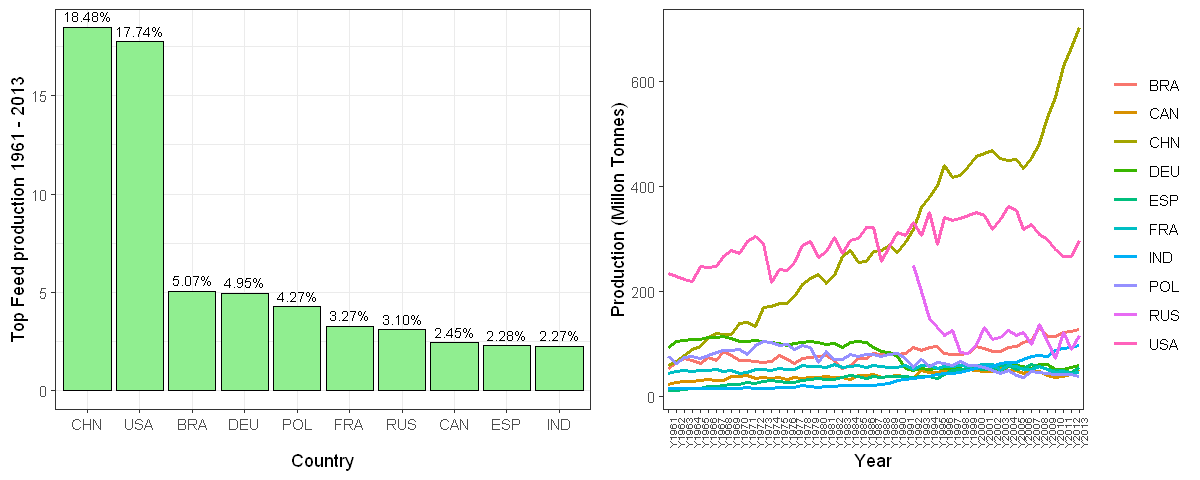

In [7]:
# the top 10 feed producers
topFeed <- fao_gath%>%
    filter(Element == "Feed")  %>% # selecting the food only
    summarise(totalprod = sum(Production)/1000)%>% # getting the total production for food
    ungroup()%>% 
    top_n(10,totalprod)

# to see the top 10 countries for feed production:
# topFeed %>% select(Area_Abb,totalprod) %>% arrange(desc(totalprod))

# using bar plot to plot top feed producers:
options(repr.plot.width=10, repr.plot.height=4)
top_feed1 <- fao %>% group_by(Area_Abb, Element) %>%filter(Element == 'Feed')%>% 
    summarise(TFO = sum(Total)) %>% ungroup()%>%mutate(pct = prop.table(TFO)*100)%>%
    top_n(10, wt = pct) %>%
    ggplot(aes(x = reorder(Area_Abb, -pct), y = pct)) + 
    geom_bar(stat = 'identity', fill = "lightgreen", aes(color = I('black')), size = 0.1) + 
    geom_text(aes(label = sprintf("%.2f%%", pct)), hjust = 0.5,
              vjust = -0.5, size = 3)+ theme_bw()+ xlab("Country") + ylab("Top Feed production 1961 - 2013")

top_feed2 <-fao_sel %>% 
    gather(Year, Production, Y1961:Y2013, na.rm = TRUE) %>% 
    group_by(Area_Abb,Year,Element) %>%
    filter(Element == "Feed" & Area_Abb %in% topFeed$Area_Abb) %>%
    summarise(totalprod = sum(Production)/1000) %>% 
    ggplot(aes(Year,totalprod,group = Area_Abb, color = Area_Abb))+  
    geom_line(size = 1) +
    ylab( "Production (Millon Tonnes)")+
    theme_bw()+theme(axis.text.x = element_text(size=6, angle=90),
                     plot.title = element_text(hjust = 0.5),
                     panel.grid = element_blank(),
                     legend.title = element_blank())

plot_grid(top_feed1,top_feed2, align = "h")

`summarise()` has grouped output by 'Area_Abb', 'Year'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Item', 'Year'. You can override using the `.groups` argument.



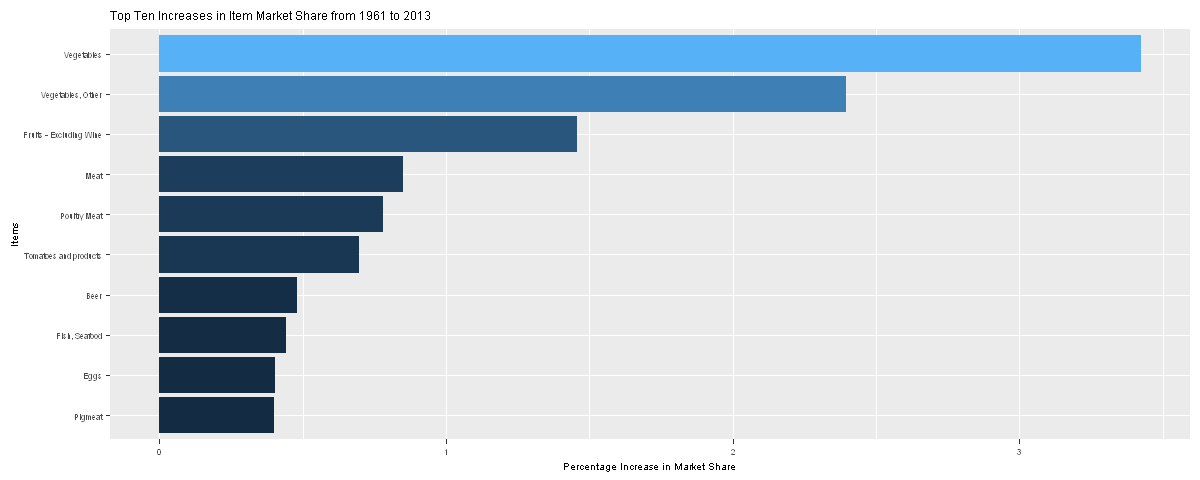

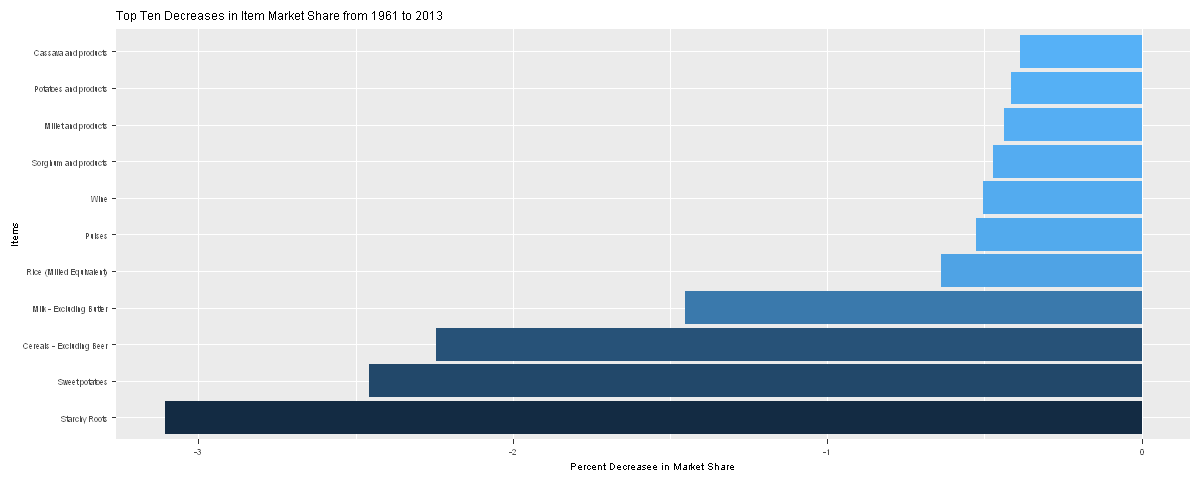

In [8]:
# Top 10 food and feed items becoming more popular over the years ----
# converting year values from character strings to integers
fao_gath$Year <- str_replace(fao_gath$Year, "[Y]", "")
fao_gath$Year <- as.integer(fao_gath$Year)
# amount of food and feed produced per year
yearlyProdTotals <- fao_gath %>%
    group_by(Area_Abb, Year, Element) %>%
    summarise(
        element_total = sum(Production, na.rm=TRUE)
    )  %>%
    group_by(Year, Element) %>%
    summarise(
        total_prod = sum(element_total, na.rm=TRUE)
    )
#  total amount for each item food and feed per year
itemTotals <- fao_gath %>%
    group_by(Item, Year, Element) %>%
    summarise(
        element_total = sum(Production, na.rm=TRUE)
    )
# join itemTotals and yealyProdTotals
itemComp <- left_join(itemTotals, yearlyProdTotals, by = c("Year", "Element"))
# percentage for each item
itemComp <- itemComp %>%
    mutate(
        percent_of_total = 100*(element_total/total_prod)
    )
# create percentage distribution for 1061 and 2013
itemPct2013 <- (itemComp %>%
                    filter(Year == 2013, Element == "Food"))[, c("Item", "percent_of_total")]
itemPct1961 <- (itemComp %>%
                    filter(Year == 1961, Element == "Food"))[, c("Item", "percent_of_total")]
# calculate change from 1961 to 2013
itemPctChange <- itemPct1961
itemPctChange$percent_of_total <- itemPct2013$percent_of_total - itemPct1961$percent_of_total
# plot top 10 items increased in market share from 1961 to 2013
item_ord <- arrange(itemPctChange, desc(percent_of_total))
item_top10 <- item_ord[1:10,]
item_low10 <- item_ord[105:115,]
item_top10 %>%
    ggplot() +
    geom_bar(aes(x = reorder(Item, percent_of_total, sum), y = percent_of_total, fill = percent_of_total), stat = "identity") +
    theme(text = element_text(size=6)) +
    xlab("Items") +
    ylab("Percentage Increase in Market Share") +
    ggtitle(label = "Top Ten Increases in Item Market Share from 1961 to 2013") +
    guides(fill = FALSE) +
    coord_flip()
# plot top 10 items decreased in market share from 1961 to 2013
item_low10 %>%
    ggplot() +
    geom_bar(aes(x = reorder(Item, percent_of_total, sum), y = percent_of_total, fill = percent_of_total), stat = "identity") +
    theme(text = element_text(size=6)) +
    xlab("Items") +
    ylab("Percent Decreasee in Market Share") +
    ggtitle("Top Ten Decreases in Item Market Share from 1961 to 2013") +
    guides(fill = FALSE) +
    coord_flip()


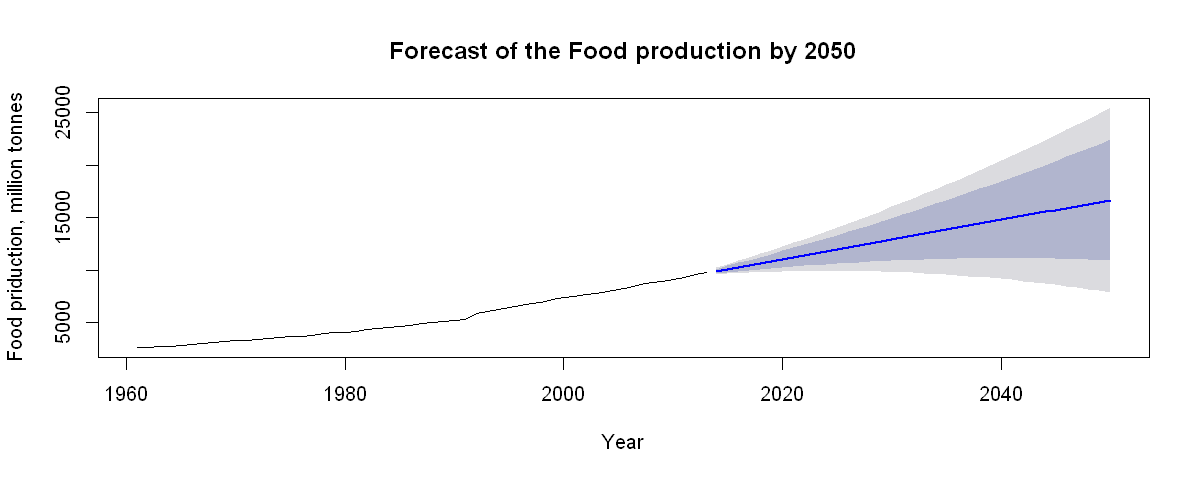

In [12]:
fao[is.na(fao)] <- 0
fao_reduced <- fao[fao$Element == 'Food', ]
long_data <- fao_reduced %>% gather(Year, Production, Y1961:Y2013)
forecast_data <- long_data %>% 
    group_by(Year) %>% 
    summarise(sum_production = sum(Production)/1000)

forecast_data_ts <- ts(forecast_data$sum_production, start = 1961, end = 2013, frequency = 1)


# Automated forecasting using an exponential model
fit <-  forecast(forecast_data_ts, h = 37, level = c(80,95)) # h - number of periods for forecasting
#level - confidence level for prediction intervals.
plot(forecast(forecast_data_ts, h = 37), main = 'Forecast of the Food production by 2050', xlab = 'Year', ylab = 'Food priduction, million tonnes')


# Appendix

In [ ]:
# loading needed libraries:

library(ggplot2)
library(dplyr)
library(tidyr)
library(stringr)
library(tibble)
library(forcats)
library(sp)
library(rworldmap)
library(cowplot)
library(forecast)

# doing some modifications for better data handeling

colnames(fao)[1] <- "Area_Abb"
colnames(fao)[2] <- "Area_Code"
colnames(fao)[3] <- "Area"
colnames(fao)[4] <- "Item_Code"
colnames(fao)[5] <- "Item"
colnames(fao)[6] <- "Element_Code"
colnames(fao)[7] <- "Element"

# selecting the most important variables:
fao_sel <- fao[,-c(2,4,6,8,9,10)]

# to make sense of the values for each year
fao_gath <- fao_sel %>% 
    gather(Year, Production, Y1961:Y2013, na.rm = TRUE) %>% 
    group_by(Area_Abb,Element) %>%
    mutate(Year = stringr::str_remove(Year, "Y"))

# to see how many missing values there are in each year:
fao_sel %>% 
    gather(Year, Production, Y1961:Y2013) %>% 
    filter(is.na(Production)) %>% 
    group_by(Year)%>% tally() %>%
    mutate(Year = stringr::str_remove(Year, "Y")) %>%
    ggplot(aes(Year,n))+
    geom_col(fill = "lightgreen")+
    theme(axis.text.x = element_text(size=6, angle=90),
          panel.background = element_blank())+
    geom_text(aes(label = sprintf("%d", n)), hjust = 0.5,
              vjust = -0.5, size = 3, check_overlap = TRUE)+
    ylab("Number of missing fields")

# the trend for total feed and food production over the years
options(repr.plot.width=10, repr.plot.height=4)
fao_sel %>% 
    gather(Year, Production, Y1961:Y2013, na.rm = TRUE) %>% 
    group_by(Element,Year)%>% # to see production development for feed and food per year
    summarise(Production = sum(Production)/1000)%>% # to get the values in million tonnes
    mutate(Year = stringr::str_remove(Year, "Y")) %>%
    ggplot(aes(Year,Production,group = Element))+  
    geom_col(aes(fill = Element),position = "dodge") + # bars of food and feed next to each other
    theme_bw()+theme(axis.text.x = element_text(size=6, angle=90),
                     plot.title = element_text(hjust = 0.5),
                     panel.grid = element_blank(),legend.title = element_blank())+
    ylab( "Production (Million Tonnes)")+
    ggtitle ( "Total Food/Feed production 1961 - 2013")

# the top 10 food producers
topFood <- fao_gath%>%
    filter(Element == "Food")  %>% # selecting the food only
    summarise(totalprod = sum(Production)/1000)%>% # getting the total production for food
    ungroup()%>% 
    top_n(10,totalprod)

# to see the top 10 countries for food production:
topFood %>% select(Area_Abb,totalprod) %>% arrange(desc(totalprod)) # in millions of tonnes

# using bar plot to plot top food producers:
options(repr.plot.width=10, repr.plot.height=4)
fao <- mutate(fao, Total=apply(fao[11:63], 1, sum, na.rm = T))
fao <- mutate(fao, last5=apply(fao[58:63], 1, sum, na.rm = T))
top_food1 <- fao %>% group_by(Area_Abb, Element) %>%filter(Element == 'Food')%>% 
    summarise(TFO = sum(Total)) %>% ungroup()%>%mutate(pct = prop.table(TFO)*100)%>%
    top_n(10, wt = pct) %>% 
    ggplot(aes(x = reorder(Area_Abb, -pct), y = pct)) + 
    geom_bar(stat = 'identity', fill = "lightgreen", aes(color = I('black')), size = 0.1) + 
    geom_text(aes(label = sprintf("%.2f%%", pct)), hjust = 0.5,
              vjust = -0.5, size = 3)+ theme_bw()+ xlab("Country") + ylab("Top Food production 1961 - 2013") 

# line plot for the top 10 food producing countries across the years:
top_food2 <-fao_sel %>% 
    gather(Year, Production, Y1961:Y2013, na.rm = TRUE) %>% 
    group_by(Area_Abb,Year,Element) %>%
    filter(Element == "Food" & Area_Abb %in% topFood$Area_Abb) %>%
    summarise(totalprod = sum(Production)/1000) %>% 
    mutate(Year = stringr::str_remove(Year, "Y")) %>%
    ggplot(aes(Year,totalprod,group = Area_Abb, color = Area_Abb))+  
    geom_line(size = 1) +
    ylab( "Production (Millon Tonnes)")+
    theme_bw()+theme(axis.text.x = element_text(size=6, angle=90),
               plot.title = element_text(hjust = 0.5),
               panel.grid = element_blank(),
              legend.title = element_blank())

plot_grid(top_food1,top_food2, align = "h")

# the top 10 feed producers
topFeed <- fao_gath%>%
    filter(Element == "Feed")  %>% # selecting the food only
    summarise(totalprod = sum(Production)/1000)%>% # getting the total production for food
    ungroup()%>% 
    top_n(10,totalprod)

# to see the top 10 countries for feed production:
topFeed %>% select(Area_Abb,totalprod) %>% arrange(desc(totalprod))

# using bar plot to plot top feed producers:
options(repr.plot.width=10, repr.plot.height=4)
top_feed1 <- fao %>% group_by(Area_Abb, Element) %>%filter(Element == 'Feed')%>% 
    summarise(TFO = sum(Total)) %>% ungroup()%>%mutate(pct = prop.table(TFO)*100)%>%
    top_n(10, wt = pct) %>%
    ggplot(aes(x = reorder(Area_Abb, -pct), y = pct)) + 
    geom_bar(stat = 'identity', fill = "lightgreen", aes(color = I('black')), size = 0.1) + 
    geom_text(aes(label = sprintf("%.2f%%", pct)), hjust = 0.5,
              vjust = -0.5, size = 3)+ theme_bw()+ xlab("Country") + ylab("Top Feed production 1961 - 2013")

# line plot for the top 10 feed producing countries across the years:
top_feed2 <-fao_sel %>% 
    gather(Year, Production, Y1961:Y2013, na.rm = TRUE) %>% 
    group_by(Area_Abb,Year,Element) %>%
    filter(Element == "Feed" & Area_Abb %in% topFeed$Area_Abb) %>%
    summarise(totalprod = sum(Production)/1000) %>% 
    ggplot(aes(Year,totalprod,group = Area_Abb, color = Area_Abb))+  
    geom_line(size = 1) +
    ylab( "Production (Millon Tonnes)")+
    theme_bw()+theme(axis.text.x = element_text(size=6, angle=90),
                     plot.title = element_text(hjust = 0.5),
                     panel.grid = element_blank(),
                     legend.title = element_blank())

plot_grid(top_feed1,top_feed2, align = "h")

# Top 10 food and feed items becoming more popular over the years ----
# converting year values from character strings to integers
fao_gath$Year <- str_replace(fao_gath$Year, "[Y]", "")
fao_gath$Year <- as.integer(fao_gath$Year)
# amount of food and feed produced per year
yearlyProdTotals <- fao_gath %>%
    group_by(Area_Abb, Year, Element) %>%
    summarise(
        element_total = sum(Production, na.rm=TRUE)
    )  %>%
    group_by(Year, Element) %>%
    summarise(
        total_prod = sum(element_total, na.rm=TRUE)
    )
#  total amount for each item food and feed per year
itemTotals <- fao_gath %>%
    group_by(Item, Year, Element) %>%
    summarise(
        element_total = sum(Production, na.rm=TRUE)
    )
# join itemTotals and yealyProdTotals
itemComp <- left_join(itemTotals, yearlyProdTotals, by = c("Year", "Element"))
# percentage for each item
itemComp <- itemComp %>%
    mutate(
        percent_of_total = 100*(element_total/total_prod)
    )
# create percentage distribution for 1061 and 2013
itemPct2013 <- (itemComp %>%
                    filter(Year == 2013, Element == "Food"))[, c("Item", "percent_of_total")]
itemPct1961 <- (itemComp %>%
                    filter(Year == 1961, Element == "Food"))[, c("Item", "percent_of_total")]
# calculate change from 1961 to 2013
itemPctChange <- itemPct1961
itemPctChange$percent_of_total <- itemPct2013$percent_of_total - itemPct1961$percent_of_total
# plot top 10 items increased in market share from 1961 to 2013
item_ord <- arrange(itemPctChange, desc(percent_of_total))
item_top10 <- item_ord[1:10,]
item_low10 <- item_ord[105:115,]
item_top10 %>%
    ggplot() +
    geom_bar(aes(x = reorder(Item, percent_of_total, sum), y = percent_of_total, fill = percent_of_total), stat = "identity") +
    theme(text = element_text(size=6)) +
    xlab("Items") +
    ylab("Percentage Increase in Market Share") +
    ggtitle(label = "Top Ten Increases in Item Market Share from 1961 to 2013") +
    guides(fill = FALSE) +
    coord_flip()
# plot top 10 items decreased in market share from 1961 to 2013
item_low10 %>%
    ggplot() +
    geom_bar(aes(x = reorder(Item, percent_of_total, sum), y = percent_of_total, fill = percent_of_total), stat = "identity") +
    theme(text = element_text(size=6)) +
    xlab("Items") +
    ylab("Percent Decreasee in Market Share") +
    ggtitle("Top Ten Decreases in Item Market Share from 1961 to 2013") +
    guides(fill = FALSE) +
    coord_flip()

# Forcasting to reflect on the coming years
fao[is.na(fao)] <- 0
fao_reduced <- fao[fao$Element == 'Food', ]
long_data <- fao_reduced %>% gather(Year, Production, Y1961:Y2013)
forecast_data <- long_data %>% 
    group_by(Year) %>% 
    summarise(sum_production = sum(Production)/1000)

forecast_data_ts <- ts(forecast_data$sum_production, start = 1961, end = 2013, frequency = 1)


# Automated forecasting using an exponential model
fit <-  forecast(forecast_data_ts, h = 37, level = c(80,95)) # h - number of periods for forecasting
#level - confidence level for prediction intervals.
plot(forecast(forecast_data_ts, h = 37), main = 'Forecast of the Food production by 2050', xlab = 'Year', ylab = 'Food priduction, million tonnes')
